In [1]:
# simplicial fraction.py
import numpy as np

from trie import Trie


def simplicial_fraction(H, min_size=2, exclude_min_size=True):
    """Computing the simplicial fraction for a hypergraph.

    """
    try:
        ns = count_simplices(H, min_size, exclude_min_size)
        ps = potential_simplices(H, min_size, exclude_min_size)
        return ns / ps
    except ZeroDivisionError:
        return np.nan


def potential_simplices(H, min_size=2, exclude_min_size=True):
    # record total number of hyperedges that are potential simplices
    return len(H.edges.filterby("size", min_size + exclude_min_size, "geq"))


def count_simplices(H, min_size=2, exclude_min_size=True):
    # build trie data structure
    t = Trie()
    all_edges = H.edges.members()
    t.build_trie(all_edges)

    edges = H.edges.filterby("size", min_size + exclude_min_size, "geq").members()

    # for each hyperedge, determine if it's a simplex
    count = 0
    # The following loop is embarassingly parallel, so parallelize to increase speed would be good
    for e in edges:
        if is_simplex(t, e, min_size):
            count += 1
    return count


def is_simplex(t, edge, min_size=2):
    for e in powerset(edge, min_size):
        if not t.search(e):
            return False
    return True


In [2]:
# simpliciality.utilities.py
from itertools import chain, combinations

import numpy as np
import xgi
from scipy.special import binom


# This implements the size-restricted power set
def powerset(iterable, min_size=1, max_size=None):
    """Generates a modified powerset.

    User can specify the maximum and minimum size
    of the sets in the powerset.

    Parameters
    ----------
    iterable : iterable
        The set for which to compute the powerset.
    min_size: int, default: 1
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces.
    max_size : int, default: None.
        The maximum size to include when computing
        the power set. When max_size=None, it generates
        the powerset including the edge itself.

    Returns
    -------
    itertools.chain
        a generator of the sets in the powerset.
    """
    s = iterable
    if max_size is None:
        max_size = len(s)

    return chain.from_iterable(
        combinations(s, r) for r in range(min_size, max_size + 1)
    )


def count_missing_subfaces(t, face, min_size=1):
    """Computing the edit distance for a single face.

    Parameters
    ----------
    t : Trie
        The trie representing the hypergraph
    face : iterable
        The edge for which to find the edit distance
    min_size: int, default: 1
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces.

    Returns
    -------
    int
        The edit distance
    """
    sub_edges = list(powerset(face, min_size=min_size, max_size=len(face) - 1))
    count = 0
    for e in sub_edges:
        if not t.search(e):
            count += 1

    return count


def missing_subfaces(t, face, min_size=1):
    """Computing the edit distance for a single face.

    Parameters
    ----------
    t : Trie
        The trie representing the hypergraph
    face : iterable
        The edge for which to find the edit distance
    min_size: int, default: 1
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces.

    Returns
    -------
    int
        The edit distance
    """
    sub_edges = list(powerset(face, min_size=min_size, max_size=len(face) - 1))
    ms = set()
    for e in sub_edges:
        if not t.search(e):
            ms.add(frozenset(e))
    return ms


def max_number_of_subfaces(min_size, max_size):
    d = 2**max_size - 2  # subtract 2 for the face itself and the empty set
    for i in range(1, min_size):
        d -= binom(max_size, i)
    return int(d)


def simplicial_assortativity(H, metric, weighted=False):
    match metric:
        case "sf":
            s = H.nodes.local_simplicial_fraction.asnumpy()
        case "es":
            s = H.nodes.local_edit_simpliciality.asnumpy()
        case "fes":
            s = H.nodes.local_face_edit_simpliciality.asnumpy()
        case _:
            raise Exception(f"{metric} is an invalid metric!")

    A = xgi.adjacency_matrix(H, sparse=False, weighted=True)
    n = A.shape[0]
    x = []
    y = []
    for i in range(n):
        for j in range(i):
            if A[i, j] and not np.isnan(s[i]) and not np.isnan(s[j]):
                if weighted:
                    x.extend([s[i]] * int(A[i, j]))
                    x.extend([s[j]] * int(A[i, j]))
                    y.extend([s[j]] * int(A[i, j]))
                    y.extend([s[i]] * int(A[i, j]))
                else:
                    x.append(s[i])
                    x.append(s[j])
                    y.append(s[j])
                    y.append(s[i])
    return np.corrcoef(x, y)[0, 1]


In [3]:



def simplicial_edit_distance(H, min_size=2, exclude_min_size=True, normalize=True):
    """Computes the simplicial edit distance.

    The number (or fraction) of sub-edges needed to be added
    to a hypergraph to make it a simplicial complex.

    Parameters
    ----------
    H : xgi.Hypergraph
        The hypergraph of interest
    min_size: int, optional
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces. For more details, see
        the Notes below. By default, 2.
    exclude_min_size : bool, optional
        Whether to exclude minimal simplices when counting simplices.
        For more detailed information, see the Notes below. By default, True.

    normalize : bool, optional
        Whether to normalize by the total number of edges

    Returns
    -------
    float
        The edit simpliciality

    See Also
    --------
    edit_simpliciality

    """
    edges = H.edges.filterby("size", min_size, "geq").members()

    t = Trie()
    t.build_trie(edges)

    maxH = xgi.Hypergraph(
        H.edges.maximal()
        .filterby("size", min_size + exclude_min_size, "geq")
        .members(dtype=dict)
    )
    if not maxH.edges:
        return np.nan

    id_to_num = dict(zip(maxH.edges, range(maxH.num_edges)))
    ms = 0
    for id1, e in maxH.edges.members(dtype=dict).items():
        redundant_missing_faces = set()
        for id2 in maxH.edges.neighbors(id1):
            if id_to_num[id2] < id_to_num[id1]:
                c = maxH._edge[id2].intersection(e)
                if len(c) >= min_size:
                    redundant_missing_faces.update(missing_subfaces(t, c, min_size))

                    # we don't have to worry about the intersection being a max face
                    # because a) there are no multiedges and b) these are all maximal
                    # faces so no inclusions.
                    if not t.search(c):
                        redundant_missing_faces.add(frozenset(c))

        mf = count_missing_subfaces(t, e, min_size)
        rmf = len(redundant_missing_faces)
        ms += mf - rmf

    if normalize:
        s = len(edges)
        mf = maxH.num_edges
        if s - mf + ms > 0:
            return ms / (s - mf + ms)
        else:
            return np.nan
    else:
        return ms

def edit_simpliciality(H, min_size=2, exclude_min_size=True):
    """Computes the edit simpliciality.

    The fraction of sub-edges contained when compared to a simplicial complex.

    Parameters
    ----------
    H : xgi.Hypergraph
        The hypergraph of interest
    min_size: int, optional
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces. For more details, see
        the Notes below. By default, 2.
    exclude_min_size : bool, optional
        Whether to exclude minimal simplices when counting simplices.
        For more detailed information, see the Notes below. By default, True.

    Returns
    -------
    float
        The edit simpliciality

    See Also
    --------
    simplicial_edit_distance
    """
    return 1 - simplicial_edit_distance(
        H, min_size=min_size, exclude_min_size=exclude_min_size
    )


def edit_simpliciality_full_construction(H, min_size=2, exclude_min_size=True):
    """Computes the simplicial edit distance.

    The number of edges needed to be added
    to a hypergraph to make it a simplicial complex.

    Parameters
    ----------
    H : xgi.Hypergraph
        The hypergraph of interest
    min_size: int, default: 1
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces.

    Returns
    -------
    int
        The edit simpliciality
    """
    edges = H.edges.filterby("size", min_size, "geq").members()
    max_edges = (
        H.edges.maximal().filterby("size", min_size + exclude_min_size, "geq").members()
    )

    t = Trie()
    t.build_trie(edges)

    ms = set()
    for e in max_edges:
        ms.update(missing_subfaces(t, e, min_size=min_size))

    s = len(edges)
    mf = len(max_edges)
    m = len(ms)
    if m + s - mf > 0:
        return (s - mf) / (m + s - mf)
    else:
        return np.nan




In [4]:


def mean_face_edit_distance(H, min_size=1, exclude_min_size=True, normalize=True):
    """Computes the mean face edit distance

    The average number (or fraction) of sub-edges needed to be added to make
    a hyperedge a simplex.

    Parameters
    ----------
    H : Hypergraph
        The hypergraph of interest
    min_size: int, optional
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces. For more details, see
        the Notes below. By default, 2.
    exclude_min_size : bool, optional
        Whether to exclude minimal simplices when counting simplices.
        For more detailed information, see the Notes below. By default, True.
    normalize : bool, optional
        Whether to normalize the face edit distance, by default True

    Returns
    -------
    float
        The mean face edit distance

    See Also
    --------
    face_edit_simpliciality

    """
    t = Trie()
    t.build_trie(H.edges.filterby("size", min_size, "geq").members())

    max_faces = (
        H.edges.maximal().filterby("size", min_size + exclude_min_size, "geq").members()
    )
    avg_d = 0
    for e in max_faces:
        if len(e) >= min_size:
            d = count_missing_subfaces(t, e, min_size=min_size)  # missing subfaces
            m = max_number_of_subfaces(min_size, len(e))
            if normalize and m != 0:
                d *= 1.0 / m
            avg_d += d / len(max_faces)
    return avg_d


def face_edit_simpliciality(H, min_size=2, exclude_min_size=True):
    """Computes the face edit simpliciality.

    The average fraction of sub-edges contained in a hyperedge
    relative to a simplex.

    Parameters
    ----------
    H : xgi.Hypergraph
        The hypergraph of interest
    min_size: int, optional
        The minimum hyperedge size to include when
        calculating whether a hyperedge is a simplex
        by counting subfaces. For more details, see
        the Notes below. By default, 2.
    exclude_min_size : bool, optional
        Whether to exclude minimal simplices when counting simplices.
        For more detailed information, see the Notes below. By default, True.

    Returns
    -------
    float
        The face edit simpliciality

    See Also
    --------
    mean_face_edit_distance

    """
    return 1 - mean_face_edit_distance(
        H, min_size=min_size, exclude_min_size=exclude_min_size
    )


In [5]:
from european_commission import EuropeanCommission
EC = EuropeanCommission('../data/', reload = False)

/home/azaiez/Documents/These/european_commission/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/home/azaiez/Documents/These/european_commission/src/orbis.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.company_data.replace('n.a.', np.nan, inplace = True)
/home/azaiez/Documents/These/european_commission/src/orbis.py:97: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behav

In [6]:
from tqdm.auto import tqdm

import os
import joblib 
import pandas as pd


# Load configuration model data
directory = '../out/simulations/'
results_mcmc = []
for file in tqdm(os.listdir(directory)):
    data = joblib.load(os.path.join(directory, file))
    results_mcmc.append(data)
df_sim = pd.DataFrame(results_mcmc)


  0%|          | 0/600 [00:00<?, ?it/s]

In [7]:
df_sim[(df_sim['mode'] == 'subdim') & (df_sim['multiedges'] == True)]['H']

6      [00358442856-45, Roberto Viola, 28666427835-74...
22     [28666427835-74, Anthony Whelan, 52431421-12, ...
37     [00358442856-45, Roberto Viola, 28666427835-74...
51     [28666427835-74, Roberto Viola, 38429111298-23...
55     [03518238467-61, Daniel Calleja Crespo, 352103...
                             ...                        
573    [03518238467-61, Daniel Calleja Crespo, 286664...
583    [28666427835-74, Roberto Viola, 352103717639-1...
587    [00358442856-45, Roberto Viola, 28666427835-74...
589    [28666427835-74, Roberto Viola, 352103717639-1...
598    [28666427835-74, Roberto Viola, 35279857524-58...
Name: H, Length: 100, dtype: object

In [8]:
H_conf =df_sim[(df_sim['mode'] == 'orga') & (df_sim['multiedges'] == True)]['H'].iloc[0].copy()
H = EC.sub_hypergraph().copy()

es_emp,fes_emp, sf_emp= [],[],[]
min_order = 3
max_order = 15

# Empirical case
for m in range(min_order,max_order):
    # Filter edges by size
    edge_ids = [e for e,size in H.size().items() if  size<= m]
    # Create subhypergraph
    sub_H = xgi.subhypergraph(H, edges = edge_ids)

    # Compute simpliciality
    sf_emp.append(simplicial_fraction(sub_H, 2))
    es_emp.append(edit_simpliciality(sub_H, 2))
    fes_emp.append(face_edit_simpliciality(sub_H, 2))

# Random case

Hs = df_sim[(df_sim['mode'] == 'orga') & (df_sim['multiedges'] == True)]['H']
sf_rand, es_rand, fes_rand = [[] for _ in range(len(Hs))], [[] for _ in range(len(Hs))], [[] for _ in range(len(Hs))]

for i, H in enumerate(Hs):
    H_conf = H.copy()
    for m in range(min_order,max_order):
        # Filter edges by size
        edge_ids = [e for e,size in H_conf.size().items() if  size<= m]
        # Create subhypergraph
        sub_H_conf = xgi.subhypergraph(H_conf, edges = edge_ids)
        # Compute simpliciality*
        sf_rand[i].append(simplicial_fraction(sub_H_conf, 2))
        es_rand[i].append(edit_simpliciality(sub_H_conf, 2))
        fes_rand[i].append(face_edit_simpliciality(sub_H_conf, 2))




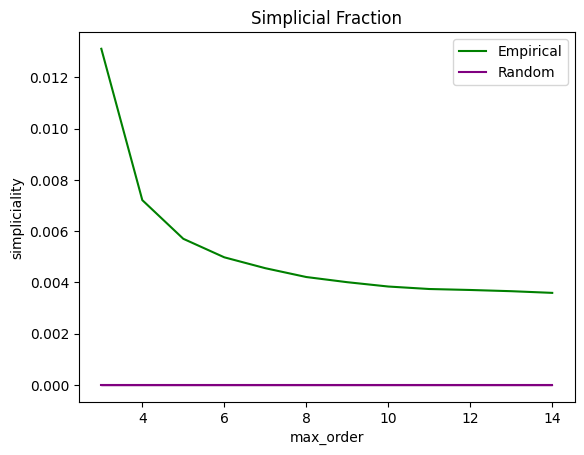

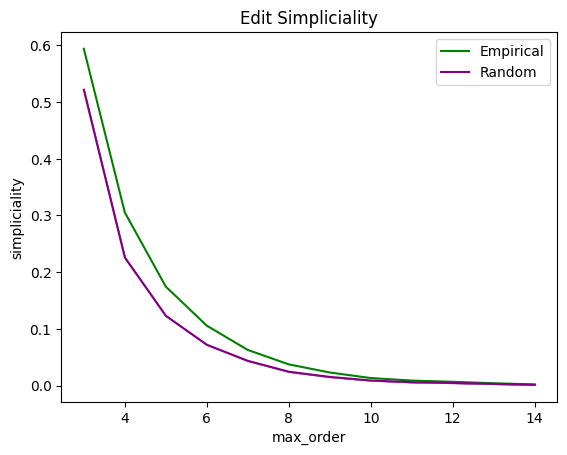

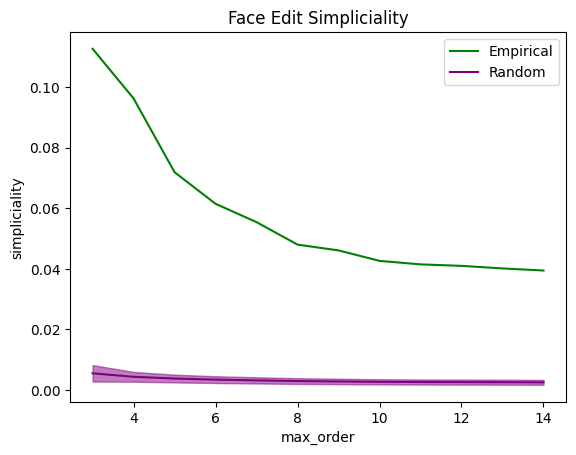

In [14]:
import matplotlib.pyplot as plt
for result_emp, result_rand, title in [(sf_emp, sf_rand, 'Simplicial Fraction'), (es_emp, es_rand, 'Edit Simpliciality'), (fes_emp, fes_rand, 'Face Edit Simpliciality')]:
    
    mean_rand = np.array(result_rand).mean(axis = 0)
    std_rand = np.array(result_rand).std(axis =0)

    plt.plot(range(min_order,max_order), result_emp, label = 'Empirical', color = 'green')
    plt.plot(range(min_order,max_order), mean_rand, label = 'Random', color = 'purple')
    plt.fill_between(range(min_order,max_order), mean_rand + std_rand, mean_rand - std_rand, alpha = 0.5, color = 'purple')
    plt.title(title)
    
    plt.xlabel('max_order')
    plt.ylabel('simpliciality')

    plt.legend()
    plt.savefig(f'../out/Figures/{title}.pdf')

    plt.show()
    plt.close()

In [20]:
mean_rand= []
emp = []
for result_emp, result_rand, title in [(sf_emp, sf_rand, 'Simplicial Fraction'), (es_emp, es_rand, 'Edit Simpliciality'), (fes_emp, fes_rand, 'Face Edit Simpliciality')]:
    emp.append(result_emp)
    mean_rand.append(np.array(result_rand).mean(axis = 0))
print(emp, mean_rand)

[[0.013114754098360656, 0.007207207207207207, 0.005698005698005698, 0.004975124378109453, 0.004550625711035267, 0.004206098843322818, 0.004004004004004004, 0.003835091083413231, 0.003738317757009346, 0.0037002775208140612, 0.0036529680365296802, 0.003587443946188341], [0.5938812237552489, 0.3053892215568862, 0.1745876204474931, 0.10574249832230853, 0.06295630686285525, 0.037520018302448, 0.023194128674564274, 0.01339280621499217, 0.008948881765151961, 0.006777138377463299, 0.004210111307457853, 0.002149756205832465], [0.11256830601093104, 0.09619047619048382, 0.07186730872124603, 0.061439597546679825, 0.055391220659383955, 0.04797506552215691, 0.04607065830344048, 0.042617547690969704, 0.041461490770184906, 0.04097171597398874, 0.04012949756245687, 0.039440790290430794]] [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.52159469, 0.22599062, 0.12322227, 0.07215336, 0.04377599,
       0.02457815, 0.01540157, 0.00910371, 0.00604993, 0.00474796,
       0.00306564, 0.00152